In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from patsy import dmatrices
from scipy import stats
from pandas.tseries.offsets import MonthBegin
warnings.filterwarnings("ignore")

% matplotlib inline

In [23]:
# com = pd.read_csv('companies_cleaned.csv',index_col=0)

In [111]:
com = pd.read_stata('WRDS_1991-2016.dta')
com['gvkey'] = com['gvkey'].apply(lambda x: str(x).replace(' ','')).astype(int)
com['cusip'] = com['cusip'].apply(lambda x: str(x).replace(' ',''))

In [112]:
for col in ['mv','cash1','rnd46','q','divyld','growth3yr','roa','b2m']:
    com.loc[com.index[pd.notnull(com[col])],col] = \
    stats.mstats.winsorize(com[pd.notnull(com[col])][col],limits = (0.01,0.01))

In [113]:
com.q.describe()

count    186356.000000
mean          5.156314
std          16.810758
min           0.389177
25%           1.076078
50%           1.569370
75%           2.936518
max         143.080210
Name: q, dtype: float64

In [114]:
com.shape

(214640, 41)

In [115]:
HFA = pd.read_csv('HFA.csv',index_col=0)

In [116]:
cpx = pd.read_csv('CPAX.csv')

In [117]:
cpx.columns = ['gvkey', 'datadate', 'yeara', 'indfmt', 'consol', 'popsrc', 'datafmt',
               'curcd', 'capx', 'costat']

In [118]:
com1 = pd.merge(com,cpx[['gvkey','yeara','capx']],on=['gvkey','yeara'],how='left')

In [119]:
com1.shape

(241871, 42)

In [120]:
com1['inv'] = com1['capx']/com1['assets6']

In [121]:
com2 = com1.drop_duplicates(subset = ['gvkey','yeara'])

In [122]:
com2.shape

(214640, 43)

# 1. ROA and Q in Excess of Industry Average

In [123]:
HFA1 = HFA[HFA.Permno != 0]

In [124]:
com3 = com2.dropna(subset=['dnum',"permno"])
com3 = com3[com3.dnum != ""]

In [125]:
com3.shape

(131944, 43)

In [126]:
com3.dnum = com3.dnum.astype(int).astype(str)
com3.dnum = com3['dnum'].apply(lambda x: x.zfill(4))

In [127]:
sic3 = com3.dnum.apply(lambda x: x[0:3])
com3['sic3'] = sic3

In [128]:
SIC = sic3.value_counts()
sic_s = SIC[SIC < 6].index
sic_l = SIC[SIC > 5].index

In [129]:
indus = com3.groupby(['sic3','yeara'])['roa','q'].mean()
indus1 = com3.groupby(["sic3"])["roa","q"].mean()
indus = indus.reset_index()
indus1 = indus1.reset_index()
indus.columns = ['sic3','yeara','roa_i','q_i']
indus1.columns = ['sic3','roa_i','q_i']

In [130]:
identify = HFA1[['Permno','year']]

In [131]:
for i in range(-3,4):
    identify['year'+str(i)] = identify.year + i

In [132]:
identify1 = identify.set_index(['Permno','year']).stack().reset_index().drop('level_2',axis=1)

In [133]:
identify1.columns = ['permno','year','yeara']

In [134]:
identify1['ylag'] = identify1.yeara - identify1.year

In [135]:
identify1.head()

,permno,year,yeara,ylag
0,88421.0,2005.0,2002.0,-3.0
1,88421.0,2005.0,2003.0,-2.0
2,88421.0,2005.0,2004.0,-1.0
3,88421.0,2005.0,2005.0,0.0
4,88421.0,2005.0,2006.0,1.0


In [136]:
df = pd.merge(identify1,com3,how='inner',on=['permno','yeara'])

In [137]:
any(df.sic3.isin(sic_s))

False

In [138]:
df1 = pd.merge(df,indus,on=['sic3','yeara'],how='inner')
df2 = pd.merge(df,indus1,on=['sic3'],how='inner')

In [139]:
df1['diff_roa'] = df1['roa'] - df1['roa_i']
df1['diff_q'] = df1['q'] - df1['q_i']
df2['diff_roa'] = df2['roa'] - df2['roa_i']
df2['diff_q'] = df2['q'] - df2['q_i']

In [140]:
series = df1.groupby(['ylag'])['roa','q','diff_roa','diff_q'].mean()
series1 = df2.groupby(['ylag'])['roa','q','diff_roa','diff_q'].mean()

In [141]:
series

,roa,q,diff_roa,diff_q
ylag,,,,
-3.0,0.058253,2.174955,0.015315,-0.522385
-2.0,0.047726,2.207937,0.005128,-0.492825
-1.0,0.035670,2.118382,-0.005199,-0.617055
0.0,0.023568,2.101552,-0.013593,-0.562958
1.0,0.034133,2.292021,-0.000902,-0.358162
2.0,0.040263,2.391770,0.005083,-0.322232
3.0,0.046895,2.387002,0.010963,-0.305120


In [142]:
series1

,roa,q,diff_roa,diff_q
ylag,,,,
-3.0,0.058253,2.174955,0.022142,-0.648025
-2.0,0.047726,2.207937,0.013013,-0.624146
-1.0,0.035670,2.118382,0.002065,-0.717890
0.0,0.023568,2.101552,-0.010894,-0.696921
1.0,0.034133,2.292021,-0.000077,-0.489995
2.0,0.040263,2.391770,0.006760,-0.393474
3.0,0.046895,2.387002,0.013324,-0.392035


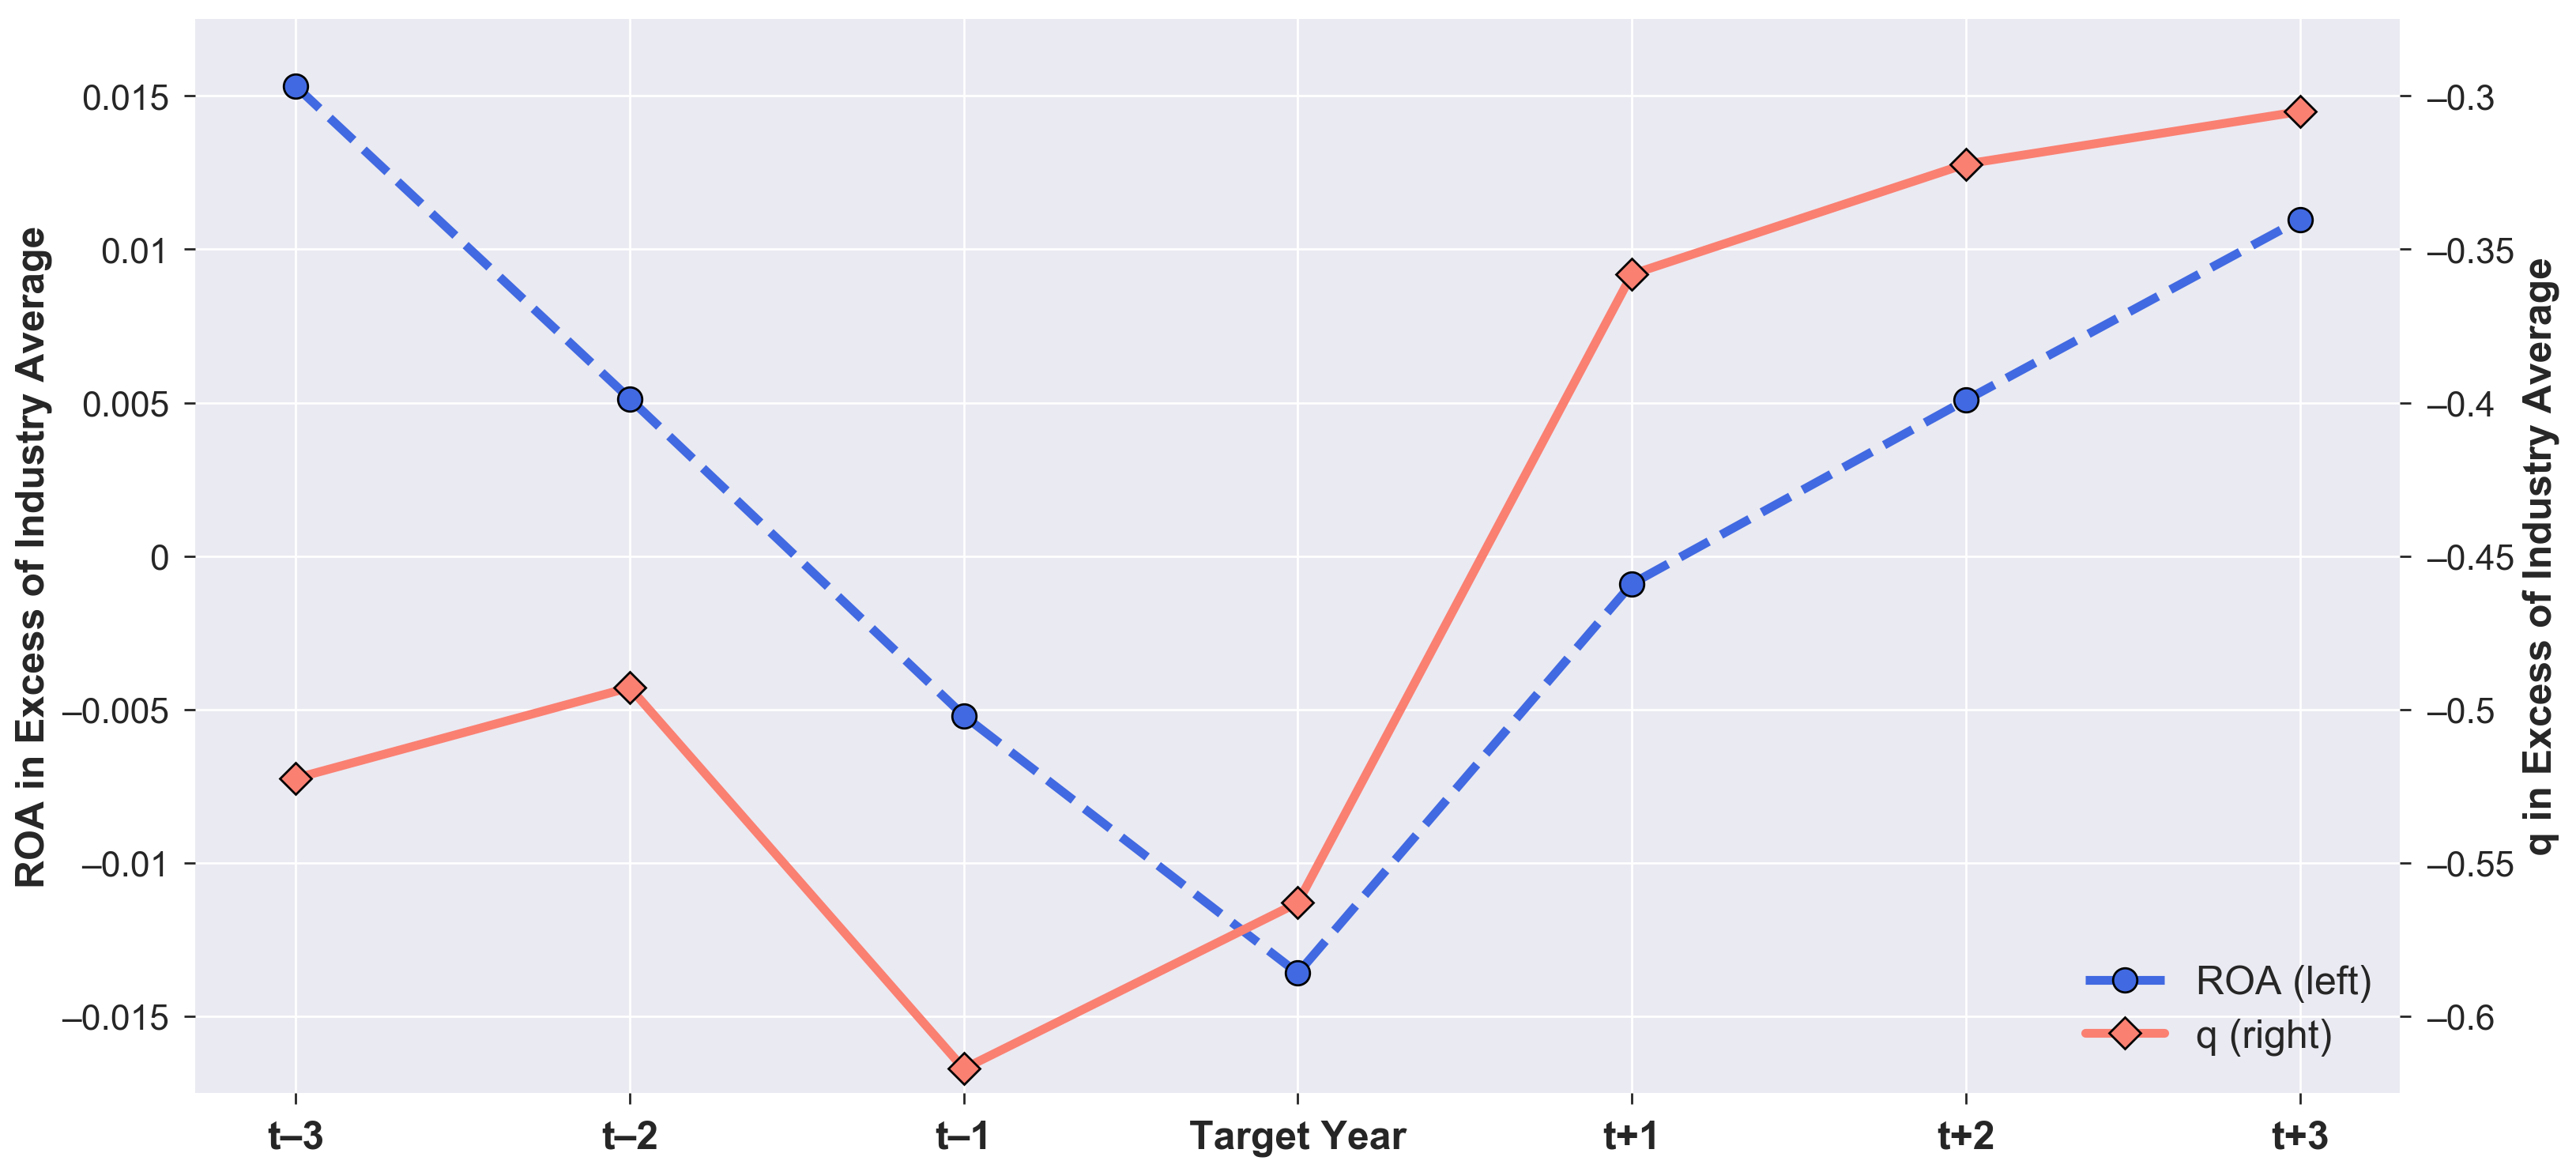

In [162]:
sns.set(style='darkgrid')
fig1 = plt.figure(figsize = (18,9),dpi=200)
ax1 = fig1.add_subplot(111)
ax1.plot(series.diff_roa,lw = 4,linestyle='--',color='royalblue',marker = 'o',markersize=11,\
         markeredgewidth=1,markeredgecolor='black')
ax1.set_xticks(np.arange(-3,4))
ax1.set_xticklabels(['t–3','t–2','t–1','Target Year','t+1','t+2','t+3'],\
                    fontsize=18,weight='bold')
ax1.set_ylim([-0.0175,0.0175])
ax1.set_yticks(np.arange(-0.015,0.016,0.005))
ax1.set_yticklabels(["–0.015",'–0.01','–0.005',0,0.005,0.01,0.015],fontsize=16)
ax2 = ax1.twinx()
ax2.grid(False)
ax2.plot(series.diff_q,lw = 4,color='salmon',marker = 'D',markersize=10,\
         markeredgewidth=1,markeredgecolor='black')
ax2.set_ylim([-0.625,-0.275])
ax2.set_yticks(np.arange(-0.6,-0.29,0.05))
ax2.set_yticklabels(['–'+str(i) for i in np.arange(0.6,0.29,-0.05)],fontsize=16)
ax2.tick_params(axis='both',direction='out',length=5,which='both')
ax1.tick_params(axis='both',direction='out',length=5,which='both')
ax1.legend(['ROA (left)'],loc=(0.85,0.07),fontsize=18)
ax2.legend(['q (right)'],loc=(0.85,0.02),fontsize=18)
ax1.set_ylabel('ROA in Excess of Industry Average',size=18,weight='bold',\
              verticalalignment='bottom')
ax2.set_ylabel('q in Excess of Industry Average',size=18,weight='bold',\
              verticalalignment='top')
plt.savefig("ROA & Q.png",dpi=400)

# 2. Panel Data

In [163]:
identify1.ylag = identify1.ylag.astype(int)
ide = pd.get_dummies(identify1,columns=['ylag'],prefix='D')

In [164]:
ide.head()

,permno,year,yeara,D_-3,D_-2,D_-1,D_0,D_1,D_2,D_3
0,88421.0,2005.0,2002.0,1,0,0,0,0,0,0
1,88421.0,2005.0,2003.0,0,1,0,0,0,0,0
2,88421.0,2005.0,2004.0,0,0,1,0,0,0,0
3,88421.0,2005.0,2005.0,0,0,0,1,0,0,0
4,88421.0,2005.0,2006.0,0,0,0,0,1,0,0


In [165]:
# for i in range(-3,4):
#     identify1['D'+str(-i)] = 1
#     ide = identify1[identify1['ylag']==i][['permno','yeara','D'+str(-i)]]
#     s = pd.merge(com1,ide,how='left',on=['permno','yeara'])
#     com1['D'+str(-i)] = s['D'+str(-i)].fillna(value=0)

In [166]:
target = ide.groupby(['permno','yeara'])[['D_-3', 'D_-2', 'D_-1', 'D_0', 'D_1',\
                                          'D_2', 'D_3']].sum()
target = target.reset_index()
target.iloc[:,2:9] = target.iloc[:,2:9].astype(bool).astype(int)

In [167]:
target[target.iloc[:,2:9].sum(axis=1) <= 1].shape

(19909, 9)

In [168]:
target.shape

(23153, 9)

In [169]:
sam = pd.merge(com3,target,how='left',on=['permno','yeara'])
sam[['D_-3', 'D_-2', 'D_-1', 'D_0', 'D_1','D_2', 'D_3']] = \
sam[['D_-3', 'D_-2', 'D_-1', 'D_0', 'D_1','D_2', 'D_3']].fillna(value=0)

In [170]:
sam1 = sam[['sic3', 'yeara', 'D_-3', 'D_-2', 'D_-1', 'D_0', 'D_1', 'D_2', 'D_3','permno',\
            'roa', 'q', 'inv','divyld', 'amex', 'altman', 'amihudi2', 'analyst', 'assets6',\
           'b2m', 'b2mquant','crspage', 'cash1', 'equity216', 'growth3yr', 'hhisic3', 'herfindahl',\
           'inst', 'levb', 'mv', 'mvquant', 'mktshrsic3', 'nyse', 'nasdaq', 'pe', 'payoutyld',\
           'rnd46', 'sp500member', 'sales12', 'shrpurchase115', 'stkretindadj', 'tdc1', 'to',\
           'divincrease', 'dnum', 'fyr', 'gvkey', 'newceo']]

In [171]:
sam2 = sam1.dropna(subset=['permno','yeara'])

In [172]:
sam2.shape

(131944, 48)

In [173]:
# sam2

In [174]:
sam2.to_csv('assign4.csv')

In [175]:
sam.columns

Index(['amex', 'altman', 'amihudi2', 'analyst', 'assets6', 'b2m', 'b2mquant',
       'crspage', 'cash1', 'equity216', 'growth3yr', 'hhisic3', 'herfindahl',
       'inst', 'levb', 'mv', 'mvquant', 'mktshrsic3', 'nyse', 'nasdaq', 'pe',
       'permno', 'payoutyld', 'q', 'rnd46', 'roa', 'sp500member', 'sales12',
       'shrpurchase115', 'stkretindadj', 'tdc1', 'to', 'cusip', 'cusip6',
       'divincrease', 'divyld', 'dnum', 'fyr', 'gvkey', 'newceo', 'yeara',
       'capx', 'inv', 'sic3', 'D_-3', 'D_-2', 'D_-1', 'D_0', 'D_1', 'D_2',
       'D_3'],
      dtype='object')